# Movie Recommendations

Recommendations are a common machine learning task widely used by many leading companies, such as Netflix, Amazon, and YouTube. If you have used any of these online services, you are familiar with recommendations that are often prefixed with "You might also like.." or "Recommended items other customers buy...".

There are many ways to generate recommendations. It could be done based on simple criteria, such as movie genre, e.g. comedies or action adventure. More sophisticated recommendations might consider many more factors, such as the director, when the movie was produced and so on.

In this example, we will use a common, straightforward method known as [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering). This method is based on idea that many customers have similar likes and dislikes. It also considers similarities between products. It's a simple, yet effective technique that depends only user preferences, such as product ratings. If you have a sufficiently large dataset of ratings from your customers, then this approach is a good place to start.

In [0]:
%tensorflow_version 1.x

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Add, Dropout
from keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# Load data

In this example, we will make movie recommendations given about 100,000 samples from roughly 10,000 customers or users.

The data set is freely available on the [MovieLens website](https://grouplens.org/datasets/movielens/).

In [188]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2019-12-14 20:56:24--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  6.03MB/s    in 0.2s    

2019-12-14 20:56:24 (6.03 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [189]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [190]:
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [191]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Join Ratings with Movies

The ratings don't contain movie titles, so let's join or merge these two sets for convenience.

In [192]:
ratings = ratings.merge(movies, on='movieId').drop(['genres','timestamp'],axis=1)
ratings.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


## Generate Sequential Identifiers

`userId` and `movieId` are not sequential, which causes problems for our model. To compensate, we can use the [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) class from [scikit-learn](https://scikit-learn.org/) to generate sequential identifiers for users and movies. The original identifiers are still available, so we can always join back to the original data set if needed.

In [193]:
user_enc = LabelEncoder()
ratings['userSeq'] = user_enc.fit_transform(ratings['userId'].values)

item_enc = LabelEncoder()
ratings['movieSeq'] = item_enc.fit_transform(ratings['movieId'].values)

ratings.head()

,userId,movieId,rating,title,userSeq,movieSeq
0,1,1,4.0,Toy Story (1995),0,0
1,5,1,4.0,Toy Story (1995),4,0
2,7,1,4.5,Toy Story (1995),6,0
3,15,1,2.5,Toy Story (1995),14,0
4,17,1,4.5,Toy Story (1995),16,0


## Train/Test Split

We will use most of the data (95%) for training and only 5% for testing. In this case, we expect to make predictions with a small subset of users, so using more data for training will improve accuracy.

In [194]:
train, test = train_test_split(ratings, test_size=0.05, random_state=0)
numUsers = len(ratings.userSeq.unique())
numMovies = len(ratings.movieSeq.unique())
print((numUsers, numMovies))
print((len(train), len(test)))

(610, 9724)
(95794, 5042)


## Recommendation Model

Collaborative filtering tries to minimize the error between a predicted value and ground truth. This is similar to many supervised machine learning problems. The model learns a set of features that similar movies share. The number of features could be as simple as the genre or more complex. The `numFeatures` variable below is a hyperparameter that can be tuned to optimize performance.

In [195]:
numFeatures = 50
dropout = 0.06

user_input = Input(shape=(1,))
user_emb = Embedding(numUsers, numFeatures)(user_input)
flat_user = Flatten()(user_emb)
user_dropout = Dropout(dropout)(flat_user)

movie_input = Input(shape=(1,))
movie_emb = Embedding(numMovies, numFeatures)(movie_input)
flat_movie = Flatten()(movie_emb)
movie_dropout = Dropout(dropout)(flat_movie)

dotProduct = Dot(axes=1)([user_dropout, movie_dropout])

user_bias = Embedding(numUsers, 1)(user_input)
movie_bias = Embedding(numMovies, 1)(movie_input)
sum = Add()([dotProduct, user_bias, movie_bias])
flat_sum = Flatten()(sum)
output = Dropout(dropout)(flat_sum)

model = Model([user_input, movie_input], output)

model.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_43 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_80 (Embedding)        (None, 1, 50)        30500       input_42[0][0]                   
__________________________________________________________________________________________________
embedding_81 (Embedding)        (None, 1, 50)        486200      input_43[0][0]                   
___________________________________________________________________________________________

## Model Training

Train on 95794 samples, validate on 5042 samples
Epoch 1/10
95794/95794 [==============================] - 15s 155us/step - loss: 7.2869 - val_loss: 2.1134
Epoch 2/10
95794/95794 [==============================] - 14s 142us/step - loss: 2.0215 - val_loss: 1.2000
Epoch 3/10
95794/95794 [==============================] - 13s 140us/step - loss: 1.6198 - val_loss: 1.0506
Epoch 4/10
95794/95794 [==============================] - 13s 139us/step - loss: 1.4778 - val_loss: 0.9693
Epoch 5/10
95794/95794 [==============================] - 13s 140us/step - loss: 1.3545 - val_loss: 0.9342
Epoch 6/10
95794/95794 [==============================] - 13s 141us/step - loss: 1.3116 - val_loss: 0.9348
Epoch 7/10
95794/95794 [==============================] - 13s 139us/step - loss: 1.2535 - val_loss: 0.9400
Epoch 8/10
95794/95794 [==============================] - 13s 138us/step - loss: 1.1769 - val_loss: 0.9358
Epoch 9/10
95794/95794 [==============================] - 13s 138us/step - loss: 1.1502 - val_l

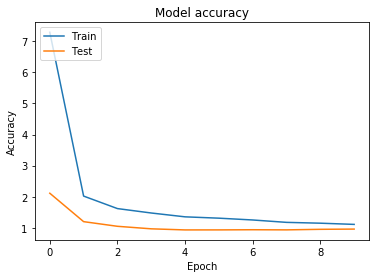

In [196]:
model.compile(loss='mean_squared_error', optimizer=Adam())
history = model.fit([train.userSeq, train.movieSeq], train.rating,
                    batch_size=32, epochs=10, verbose=1,
                    validation_data=([test.userSeq, test.movieSeq], test.rating))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Make Predictions

We can make predictions for a given user by creating a numpy array of all movies and a numpy array of the same dimension filled with just the one user we are interested in. The model will predict ratings for the specified user given all movies in the test data set.

We can then sort the data set by predicted rating descending to get the best recommendations first.

In [197]:
# The user for whom we want to make recommendations
userNumber = 0

movie_vector = test.movieSeq.values
user_vector = np.ones((len(test),)) * userNumber
predictions = model.predict([user_vector, movie_vector])
pSeries = pd.Series([a[0] for a in predictions])
predictedDF = test.copy()
predictedDF['Predictions'] = pSeries

predictedDF.drop_duplicates(subset=['movieSeq']).sort_values(by='Predictions', ascending=False).head(10)

,userId,movieId,rating,title,userSeq,movieSeq,Predictions
2930,579,367,4.0,"Mask, The (1994)",578,325,5.097548
1696,308,260,2.5,Star Wars: Episode IV - A New Hope (1977),307,224,4.884718
4589,1,596,5.0,Pinocchio (1940),0,513,4.788651
3731,452,527,5.0,Schindler's List (1993),451,461,4.693644
2950,414,423,2.0,Blown Away (1994),413,367,4.671918
355,559,6,5.0,Heat (1995),558,5,4.599598
1194,434,163,3.0,Desperado (1995),433,136,4.574470
184,534,1,4.0,Toy Story (1995),533,0,4.553178
4955,470,648,3.0,Mission: Impossible (1996),469,546,4.550874
2784,541,362,5.0,"Jungle Book, The (1994)",540,320,4.447228


## Error Analysis

Let's look at some movies where the ground truth did not compare well with predictions.

In [198]:
oneUser = predictedDF[predictedDF.userSeq == userNumber].copy()
oneUser['Error'] = (oneUser.rating - oneUser.Predictions)**2
oneUser.sort_values(by='Error', ascending=False).head(5)

,userId,movieId,rating,title,userSeq,movieSeq,Predictions,Error
2946,1,423,3.0,Blown Away (1994),0,367,4.574666,2.479573
3570,1,527,5.0,Schindler's List (1993),0,461,3.757696,1.543318
369,1,47,5.0,Seven (a.k.a. Se7en) (1995),0,43,4.328542,0.450856
4992,1,661,5.0,James and the Giant Peach (1996),0,551,4.354843,0.416227
4589,1,596,5.0,Pinocchio (1940),0,513,4.788651,0.044669


In [199]:
ratings[ratings.movieSeq == 367]

,userId,movieId,rating,title,userSeq,movieSeq
2946,1,423,3.0,Blown Away (1994),0,367
2947,19,423,3.0,Blown Away (1994),18,367
2948,217,423,3.0,Blown Away (1994),216,367
2949,268,423,2.0,Blown Away (1994),267,367
2950,414,423,2.0,Blown Away (1994),413,367
2951,438,423,3.0,Blown Away (1994),437,367
2952,599,423,2.5,Blown Away (1994),598,367
2953,603,423,4.0,Blown Away (1994),602,367
2954,607,423,3.0,Blown Away (1994),606,367
2955,608,423,3.0,Blown Away (1994),607,367
